# **GPT Models**

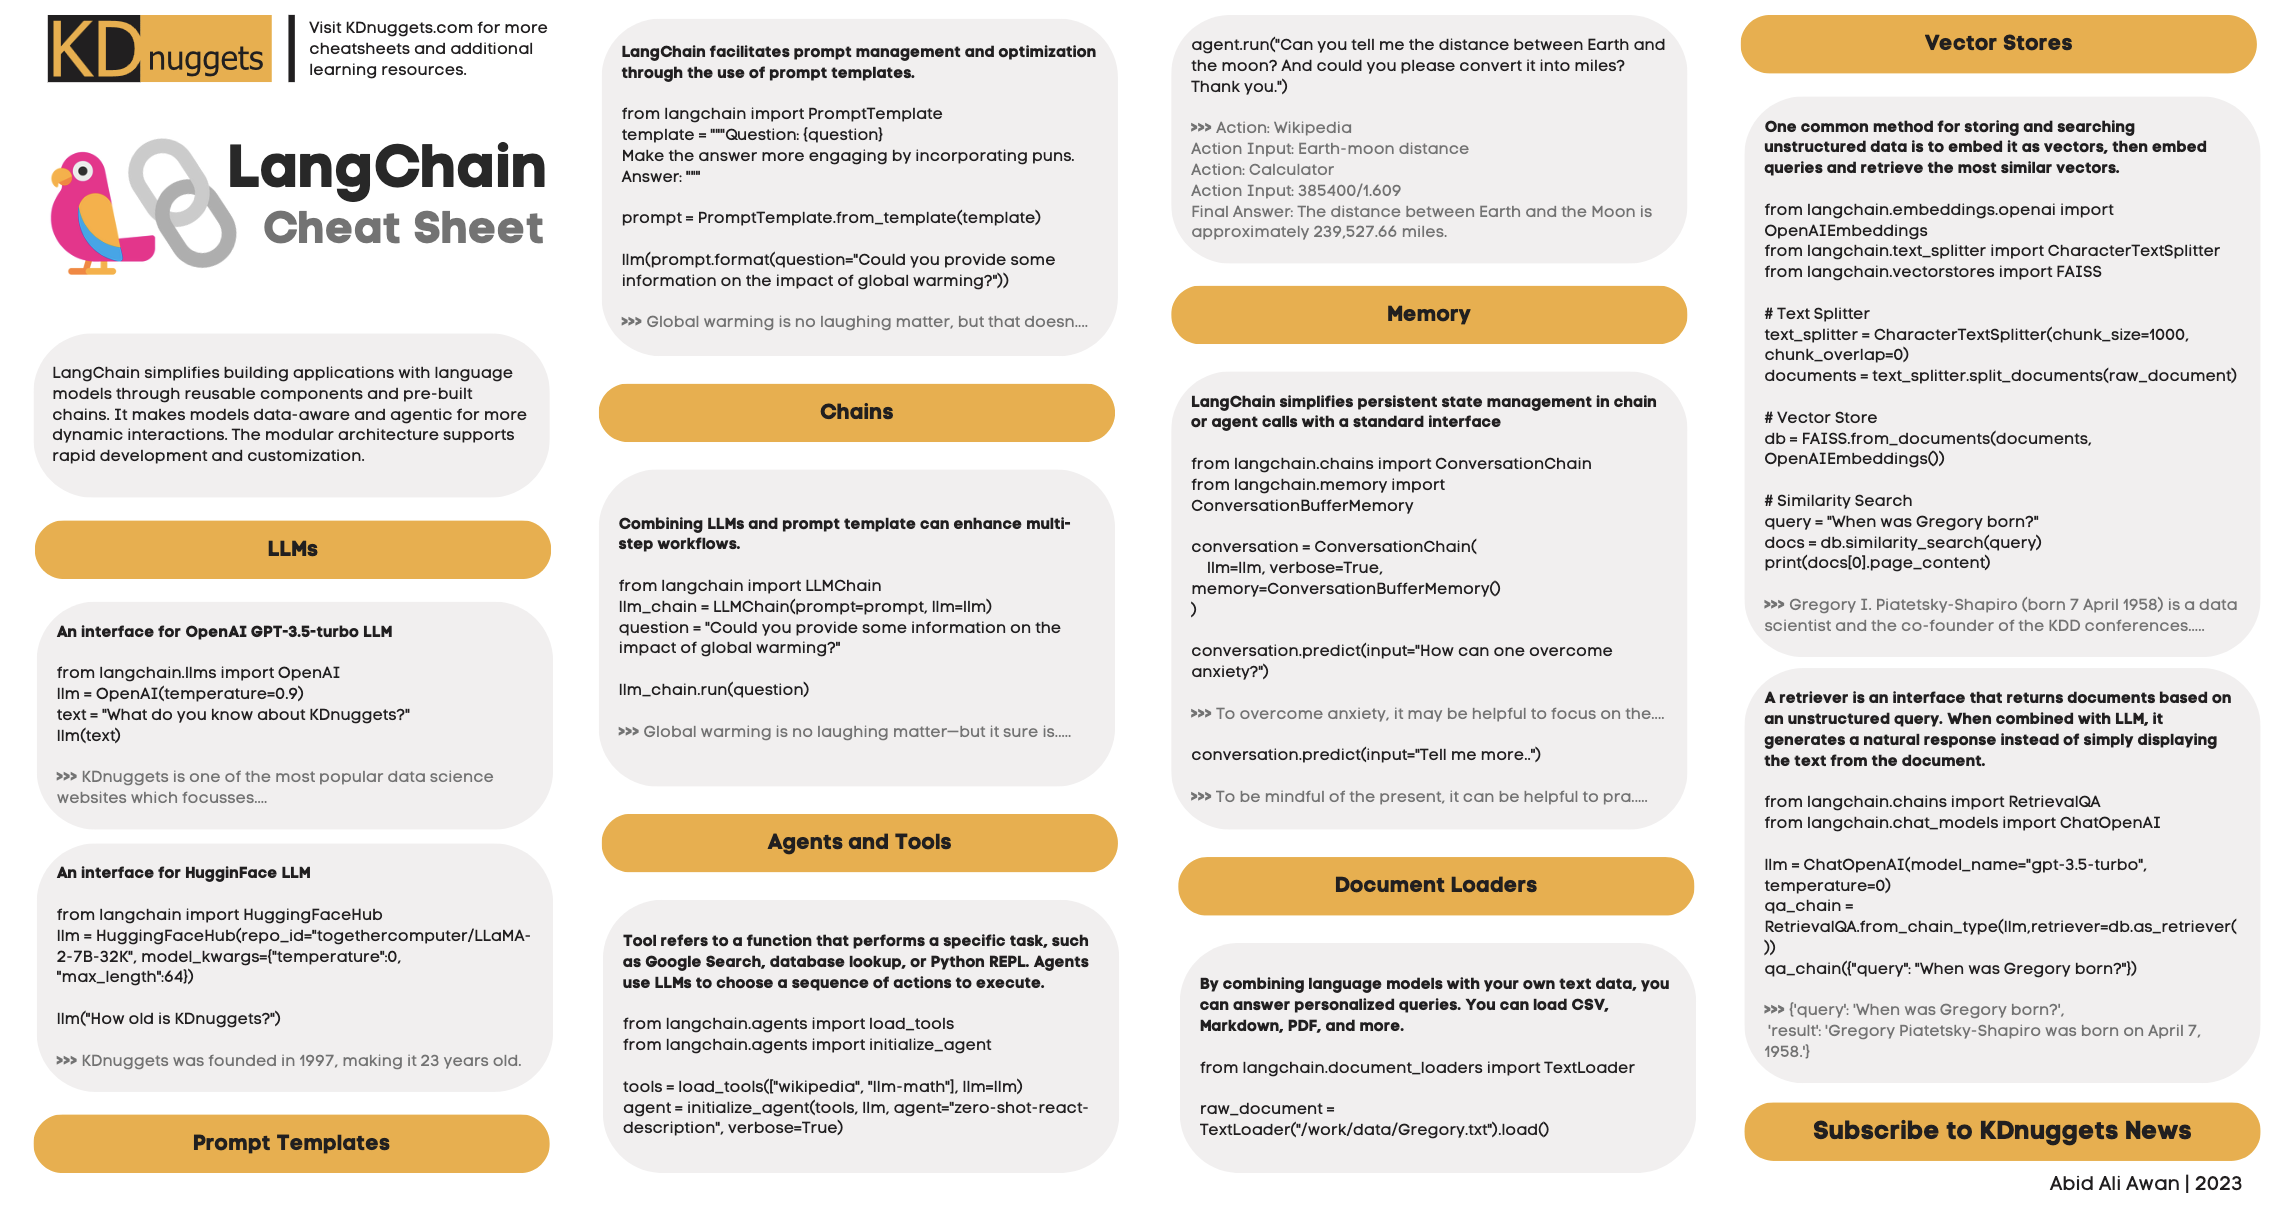




## Task Description
Your task is to create a system that uses RAG for extracting information from a set of documents or a document which can be either a scientific paper or report. This involves integrating a database to store vectors of document information and designing customized prompts to effectively use GPT models for generation. Here are some project ideas:

**1.   Build a QA system that retrieves information from a given set of documents (or a document) to answer complex queries.**

**2.   Develop a tool for summarizing research papers, where the system extracts key points from a database of paper vectors.**

*3.   Create a recommendation engine that suggests content based on user queries and retrieved document data.*

*4.   Explore other innovative applications of RAG, such as automated content generation, data analysis, or any other creative use case you can envision.*

We have made No one and two:
*   QA system that retrieves information from a given set of documents
*   A tool for summarizing research papers

**Key Components**

*   **Database Integration:** Set up a database to store and retrieve vectors representing document information.
*   **Customized Prompts:** Design and implement prompts that effectively utilize GPT models for generation based on retrieved data.
*   **RAG Implementation:** Use Langchain to integrate retrieval-augmented generation in your system.

**Delivery**

*   Create a dedicated GitHub repository for this assignment.
*   Store all relevant materials, including the Colab notebook, in the repository.
*   Provide a README.md file with a concise description of the assignment and its components.
*   You may work individually or in groups of up to three members.
*   Submit your work by emailing a link to the repository to Hamid (hamidb@business.aau.dk).

## Group Members

*   Benjamin Ly - 20205432
*   Camilla Dyg Hannesbo - 20202923
*   Tobias Moesgård Jensen - 20231658


## Setup and install for the notebook

In [ ]:
# See which GPU you are working on
!nvidia-smi

Tue Mar  5 08:28:18 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import  torch

# Checking CUDA availability
print(torch.cuda.is_available())

True


In [ ]:
%time
!pip install pypdf --q
!pip install -qqq chromadb==0.4.10 --progress-bar off
!pip install -qqq langchain==0.0.299 --progress-bar off
!pip install -qqq sentence_transformers==2.2.2 --progress-bar off

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 4.53 µs
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.1/286.1 kB 2.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done


In [ ]:
# get a token: https://huggingface.co/docs/api-inference/quicktour#get-your-api-token

from getpass import getpass

HUGGINGFACEHUB_API_TOKEN = getpass()

··········


In [ ]:
import os

os.environ["HUGGINGFACEHUB_API_TOKEN"] = HUGGINGFACEHUB_API_TOKEN

In [ ]:
# import required libraries
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import CharacterTextSplitter
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.llms import HuggingFaceHub
from langchain.vectorstores import Chroma
from langchain.chains import ConversationalRetrievalChain
from langchain.prompts import PromptTemplate
from langchain.chains import RetrievalQA

### **1. QA system**

**Build a QA system that retrieves information from a given set of documents (or a document) to answer complex queries**

First we want to buid a QA system that retrieves information. Building a question-answering (QA) system involves developing a computational model capable of extracting relevant information from a given set of documents to answer complex queries posed by users. The system's primary goal is to understand natural language questions and provide accurate and relevant answers based on the available information.

Key components of a QA system typically include natural language processing (NLP) techniques for text understanding, information retrieval methods to locate relevant documents, and machine learning models for extracting answers from the retrieved documents. These components work together to enable the system to comprehend questions, search for relevant information, and generate appropriate responses.

Overall, a well-designed QA system can provide valuable assistance in various domains, including education, healthcare, customer support, and more, by automating the process of information retrieval and answering queries efficiently and accurately.

#### Setup the environment

In [ ]:
# Import necessary modules
from langchain.chains import RetrievalQA
from langchain import PromptTemplate

In [ ]:
# Load the PDF file and split it into smaller chunks
loader = PyPDFLoader('StrategicChange.pdf')  # Create a PyPDFLoader object with the specified PDF file

docs = loader.load()  # Load the PDF and split it into smaller chunks
len(docs)  # Get the number of chunks/documents extracted from the PDF

17

In [ ]:
# check documents
# docs

#### Preprocessing of the data

This code prepares the text data extracted from the PDF by splitting it into smaller, more manageable chunks, which can then be processed further for analysis or other tasks.

Splitting the document into chunks is required due to the limited number of tokens a LLM can look at once (4096 for Llama 2).

Next, we'll use the HuggingFaceEmbeddings class to create embeddings for the chunks:

In [ ]:
# Split the documents into smaller chunks
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1024, chunk_overlap=64)  # Create a RecursiveCharacterTextSplitter object with specified parameters
texts = text_splitter.split_documents(docs)  # Split the documents into smaller chunks using the text splitter
len(texts)  # Get the number of smaller text chunks created

67

In the spirit of using free tools, we're also using free embeddings hosted by HuggingFace. We'll use Chroma database to store/cache the embeddings and make it easy to search them:


#### Transformer Model Adaptation

In [ ]:
# Generate embeddings from Hugging Face model
embeddings = HuggingFaceEmbeddings(
    model_name="thenlper/gte-large",  # Specify the name of the pre-trained model
    model_kwargs={"device": "cuda"},   # Set device to "cuda" for GPU acceleration, change to "cpu" if using CPU
    encode_kwargs={"normalize_embeddings": True},  # Specify additional encoding parameters
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


.gitattributes:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/67.9k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/619 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/670M [00:00<?, ?B/s]

onnx/config.json:   0%|          | 0.00/632 [00:00<?, ?B/s]

model.onnx:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

onnx/special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

onnx/tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

onnx/tokenizer_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

onnx/vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/670M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

In [ ]:
# Generate embeddings for the content of the first document chunk
query_result = embeddings.embed_query(texts[0].page_content)  # Embed the content of the first document chunk
print(len(query_result))  # Print the length of the embeddings generated

1024


This code enables similarity search functionality on a collection of text documents based on their embeddings, allowing for efficient retrieval of relevant information related to a given query.

In [ ]:
# Import the Chroma vector store from the langchain package
from langchain.vectorstores import Chroma

# Create a Chroma vector store from the provided documents and embeddings
# Specify the directory to persist the vector store
db = Chroma.from_documents(texts, embeddings, persist_directory="db")

# Perform similarity search using the Chroma vector store
# Search for documents similar to the query "Transformer models" and retrieve the top k results
results = db.similarity_search("Transformer models", k=2)

DOI:10.1002/jscBUNDLING OR 
UNBUNDLINGSUBSTITUTES
OTHER 
TECHNOLOGIESEMOTIONAL
DO IT 
YOURSELF
Figure 12. Porter’s micro forces: substitutes.FORWARD 
INTEGRATIONSUPPLIER 
POWER
SIZE AND 
NUMBERRESOURCE 
SCARCITY
UNIQUE 
KNOWLEDGE
Figure 13. Porter’s micro forces: supplier power.
 10991697, 2006, 5, Downloaded from https://onlinelibrary.wiley.com/doi/10.1002/jsc.764 by Aalborg University Library, Wiley Online Library on [21/02/2024]. See the Terms and Conditions (https://onlinelibrary.wiley.com/terms-and-conditions) on Wiley Online Library for rules of use; OA articles are governed by the applicable Creative Commons License


#### LLM setup

This code sets up an instance of Mistral-7B for question answering, enabling the model to generate responses to input queries.

In [ ]:
# Import necessary modules
from langchain.chains import RetrievalQA
from langchain import PromptTemplate

In [ ]:
# We are using Mistral-7B for this question answering
# Use mistralai/Mistral-7B-v0.1 or mistralai/Mistral-7B-Instruct-v0.1 - if other don't work
repo_id = "mistralai/Mistral-7B-Instruct-v0.1"
llm = HuggingFaceHub(repo_id=repo_id, model_kwargs={"temperature":0.2, "max_new_tokens":200})

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'InferenceApi' (from 'huggingface_hub.inference_api') is deprecated and will be removed from version '1.0'. `InferenceApi` client is deprecated in favor of the more feature-complete `InferenceClient`. Check out this guide to learn how to convert your script to use it: https://huggingface.co/docs/huggingface_hub/guides/inference#legacy-inferenceapi-client.
  warnings.warn(warning_message, FutureWarning)


In [ ]:
# Define a template for generating prompts
prompt_template = """
<s>[INST] <<SYS>>
Act as a company strategy consulting. Use the following information to answer the question at the end.
<</SYS>>

{context}

{question} [/INST]
"""

In [ ]:
# Create a PromptTemplate object with the defined template and input variables
prompt = PromptTemplate(template=prompt_template, input_variables=["context", "question"])

In [ ]:
# Initialize a RetrievalQA chain for question answering
# Specify the large language model (LLM), retriever, and chain type kwargs
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,  # Large language model (LLM) for generating responses
    chain_type="stuff",  # Specify the chain type
    retriever=db.as_retriever(search_kwargs={"k": 2}),  # Specify the retriever with search parameters
    return_source_documents=True,  # Return source documents along with the response
    chain_type_kwargs={"prompt": prompt},  # Additional chain type kwargs, including the prompt template
)

The five forces in the industry analysis are:

1. Threat of New Entrants
2. Bargaining Power of Suppliers
3. Bargaining Power of Buyers
4. Threat of Substitute Products or Services
5. Competitive Rivalry in the Industry


In [ ]:
# Perform question answering with the initialized QA chain
# Provide the input question as a string
result = qa_chain(
    "What are the five forces in the industry analysis?"
)

# Print the result, stripping any leading or trailing whitespace
print(result["result"].strip())

### **2. Summarizing tool**


**Develop a tool for summarizing research papers, where the system extracts key points from a database of paper vectors.**

Creating a tool for summarizing research papers involves building a system capable of extracting key points and important information from a database of paper vectors. This tool aims to condense lengthy research papers into concise summaries, providing users with a quick overview of the main findings and insights without the need to read the entire document.

This code demonstrates how to use the developed tool for summarizing research papers by providing an input question and retrieving a concise summary as the output

In [ ]:
# Import the textwrap module for text formatting
from textwrap import fill

In [ ]:
# Perform question answering with the initialized QA chain
# Provide the input question as a string to summarize the paper on "Strategic Change"
result = qa_chain(
    "Summarize the paper of Strategic Change"
)

# Print the summarized result with text wrapping to fit within 80 characters per line
print(fill(result["result"].strip(), width=80))

The paper "Strategic Change" discusses the concept of strategic change and its
importance in business. The authors argue that strategic change is a crucial
process that organizations must undertake in order to remain competitive and
adapt to changing market conditions. They discuss various approaches to
strategic change, including logical incrementalism, radical innovation, and
organizational learning. The paper also explores the role of leadership in
strategic change and the importance of aligning organizational culture with the
new strategy. Overall, the authors emphasize the need for a systematic and
strategic approach to change management in order to achieve long-term success.
